# Analyse factorielle des correspondances

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as stats

In [10]:
from fanalysis.ca import CA

## Catégories socio-professionnelles et filières d'études


__!!! Ajouter bibliographie__

* Ricco Rakotomalala, Pratique des Méthodes Factorielles avec Python Version 1.0, 2020, chapitre 4. En ligne: <https://tutoriels-data-mining.blogspot.com/2020/07/pratique-des-methodes-factorielles-avec.html>.

* Bennani Dosse Mohammed, _Statistique bivariée avec R_, Rennes, PUR, 2011, chapitre 2.





### Tableau de contingence

Données issues de Rakotomalala, Pratique, 2020, ch.4.

In [11]:
d = {'ExpAgri':[80,99,65,58], 'Patron':[168,137,208,62], 'CadreSup':[470,400,876,79], 
     'Employe': [145,133,135,54], 'Ouvrier':[166,193,127,129]}
ddf = pd.DataFrame(d)
ddf = ddf.transpose()
ddf.columns= ['Droit', 'Sciences', 'Medecine','IUT']
D = ddf.copy(deep=True)
D

,Droit,Sciences,Medecine,IUT
ExpAgri,80,99,65,58
Patron,168,137,208,62
CadreSup,470,400,876,79
Employe,145,133,135,54
Ouvrier,166,193,127,129


In [12]:
## Ajouter une ligne
ddf.loc['Total']= ddf.sum()
## Ajouter une colonnne
ddf['Total'] = ddf.sum(axis=1)

ddf

,Droit,Sciences,Medecine,IUT,Total
ExpAgri,80,99,65,58,302
Patron,168,137,208,62,575
CadreSup,470,400,876,79,1825
Employe,145,133,135,54,467
Ouvrier,166,193,127,129,615
Total,1029,962,1411,382,3784


In [13]:
## Nombre de modalités ligne, 
# variable: catégories socio-professionnelles des parents
K = D.shape[0]
## Nombre de modalités colonnes,
# variable : filière d'études chosie
L = D.shape[1]
# Effectif total
n = np.sum(D.values)
# Nombre max. de facteur
Hmax = np.min([K-1,L-1])

print('Dimensions: (', K, ',', L, '), effectif:', n, ', nombre max. facteurs:', Hmax)

Dimensions: ( 5 , 4 ), effectif: 3784 , nombre max. facteurs: 3


In [14]:
### Valeurs produites par une fonction
statistic, p, dof, expected = stats.chi2_contingency(D)

print('Chi2 :', statistic, ', dof :',dof)
print('p-value :', p)


print('phi2 = inertie (variance totale) :', statistic/n)


### Tableau à l'indépendance
dfe = round(pd.DataFrame(expected),4)

### Coéfficient de Cramer
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.contingency.association.html

vc = stats.contingency.association(D.iloc[:-1,:-1], method='cramer')
print('Cramer: ', vc)

Chi2 : 320.2658717522244 , dof : 12
p-value : 2.582612649831932e-61
phi2 = inertie (variance totale) : 0.08463685828547157
Cramer:  0.1229600887381149


In [15]:
### Utilisation librairies fanalysis pour calculer les valeurs
# des facteurs et axes factoriels
afc = CA(row_labels=D.index,col_labels=D.columns)
afc.fit(D.values)

CA(col_labels=Index(['Droit', 'Sciences', 'Medecine', 'IUT'], dtype='object'),
   row_labels=Index(['ExpAgri', 'Patron', 'CadreSup', 'Employe', 'Ouvrier'], dtype='object'))

En analyse factorielle, le tableau des écarts à l'indépendance est décomposé en plusieurs tableaux *définis par leur marges*.

Voir à ce sujet les explications et exemples de Philippe Cibois, L'analyse factorielle, ... et le polycopié de son cours en version digitale Philippe Cibois, *Principe de l’analyse factorielle*, 2006, p.9.


<div>
    <img src="graphics/cibois_tableaux_facteurs.jpg" width="600"/>
</div>



Pour chaque on calcule le chi-2 et on obtient ainsi la contribution de chaque tableau à l'inertie, qu'on appelle aussi *valeur propre* (eigenvalue). Image issue de Philippe Cibois, *Principe de l’analyse factorielle*, 2006, p.32.

<div>
    <img src="graphics/cibois_contribution_facteurs.jpg" width="600"/>
</div>



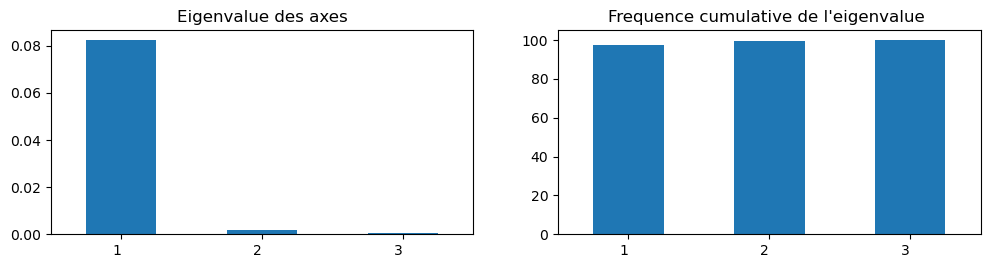

In [16]:
### Diagramme des valeurs propres et des fréquences cumulées
eig = pd.DataFrame(afc.eig_)

r1 = eig.iloc[0]
r2 = eig.iloc[2]
s=list(range(1,len(r1)+1))
r1.index=s
r2.index=s

# https://www.statology.org/pandas-subplots/
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,3))

r1.plot(kind='bar', ax=axes[0], title='Eigenvalue des axes')
r2.plot(kind='bar', ax=axes[1], title="Frequence cumulative de l'eigenvalue ")
# Met les valeurs xticks en vertical
fig.autofmt_xdate(rotation=0)
plt.show()

### Profils des lignes

In [9]:
# Calcul des profils des lignes
prof_lig = np.apply_along_axis(arr=D.values,axis=1,
                               func1d=lambda x:x/np.sum(x))
# Calul du profil marginal correspondant
# Cf. ligne grisée de Figure 100, Rakotomalala, 2020
tot_col = ddf.loc['Total'][:4]
prof_marg_lig = tot_col/np.sum(tot_col)

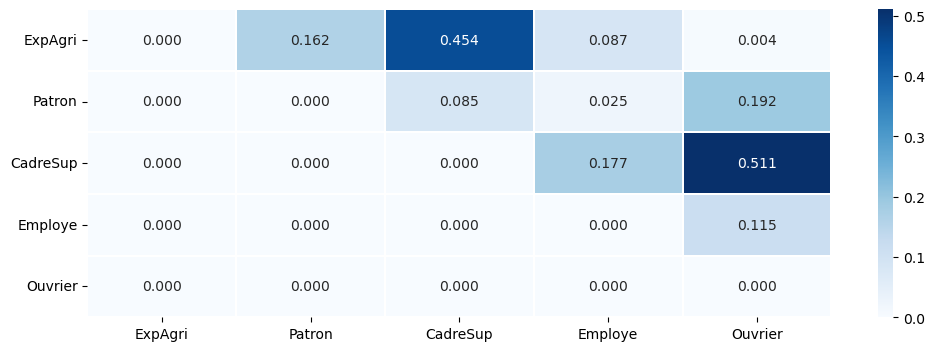

In [10]:
### Distance entre paires de modalités lignes,
# calculée sur la base des valeurs dans la note précédente
fig, ax = plt.subplots(figsize=(12,4))

distPairesLig = np.zeros(shape=(prof_lig.shape[0],prof_lig.shape[0]))
#double boucle
for i in range(prof_lig.shape[0]-1):
    for j in range(i+1,prof_lig.shape[0]):
        distPairesLig[i,j] = np.sum((prof_lig[i,:]-prof_lig[j,:])**2/prof_marg_lig)

sns.heatmap(distPairesLig,vmin=0,vmax=np.max(distPairesLig),linewidth=0.1,cmap=
'Blues',xticklabels=D.index,yticklabels=D.index, 
fmt=".3f", annot=True)

### ATTENTION: plus la couleur est foncée, plus la distance est grande
plt.show()

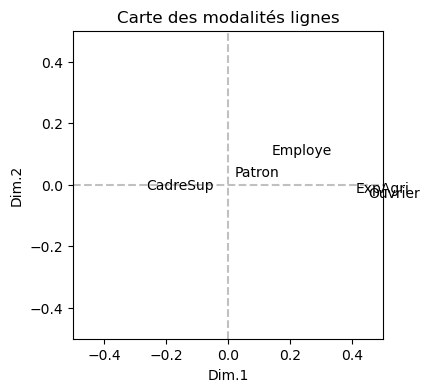

In [13]:
### Affichage des modalités lignes, axes 1 et 2 
# dans le premier plan factoriel
fig, ax = plt.subplots(figsize=(4,4))
ax.axis([-0.5,+0.5,-0.5,+0.5])
ax.plot([-0.5,+0.5],[0,0],color='silver',linestyle='--')
ax.plot([0,0],[-0.5,+0.5],color='silver',linestyle='--')
ax.set_xlabel("Dim.1")
ax.set_ylabel("Dim.2")
plt.title("Carte des modalités lignes")
for i in range(D.shape[0]):
    ax.text(afc.row_coord_[i,0],afc.row_coord_[i,1],D.index[i])
plt.show()

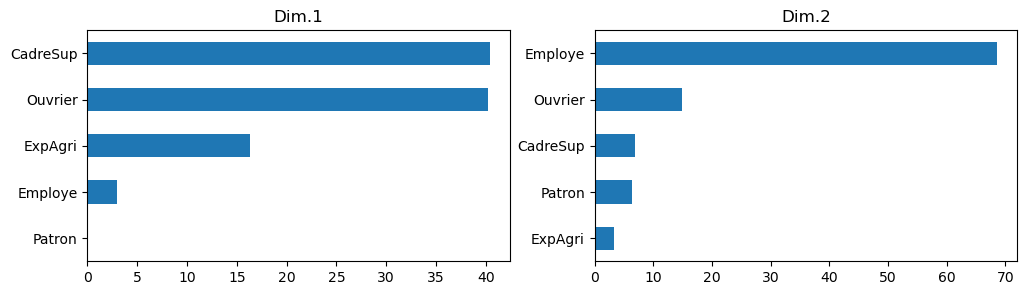

In [17]:
# Informations sur les contributions des lignes
df = afc.row_topandas()[['row_contrib_dim1',
                         'row_contrib_dim2']]
                         
r1 = df.iloc[:,0]
r2 = df.iloc[:,1]

# https://www.statology.org/pandas-subplots/
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,3))


r1.sort_values().plot(kind='barh', ax=axes[0], title='Dim.1')
r2.sort_values().plot(kind='barh', ax=axes[1], title='Dim.2')

plt.show()


### Profils des colonnes

In [18]:
# Profil marginal des filières (colonnes)
tot_lig = np.sum(D.values,axis=1)
prof_marg_col = tot_lig/np.sum(tot_lig)

# Tableau des profils colonnes
prof_col = np.apply_along_axis(arr=D.values,axis=0,
                               func1d=lambda x:x/np.sum(x))
#print(pd.DataFrame(prof_col,index=D.index,columns=D.columns))

In [19]:
### Transposer pour garder la structure du code Python des lignes 
t_prof_col = prof_col.T
# t_prof_col

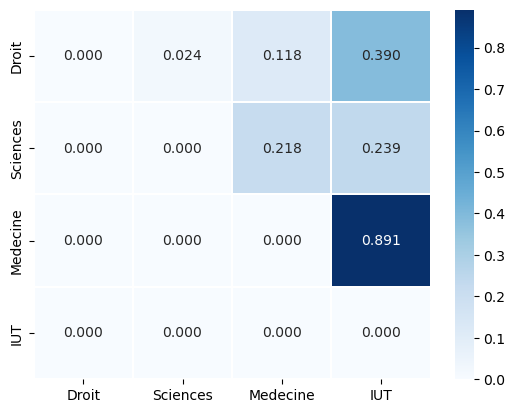

In [20]:
### Distance entre paires de modalités colonnes,
# calculée sur la base des valeurs précédentes  
distPairesCol = np.zeros(shape=(t_prof_col.shape[0],
                                t_prof_col.shape[0]))
#double boucle
for i in range(t_prof_col.shape[0]-1):
    for j in range(i+1,t_prof_col.shape[0]):        
        distPairesCol[i,j] = np.sum((t_prof_col[i,:]-t_prof_col[j,:])**2/prof_marg_col)
#distPairesLig[j,i] = distPairesLig[i,j]
#affichage
#print(pd.DataFrame(distPairesLig,index=D.index,columns=D.index))

sns.heatmap(distPairesCol,vmin=0,vmax=np.max(distPairesCol),
            linewidth=0.1,cmap='Blues',xticklabels=D.columns,
            yticklabels=D.columns, 
fmt=".3f", annot=True)

plt.show()

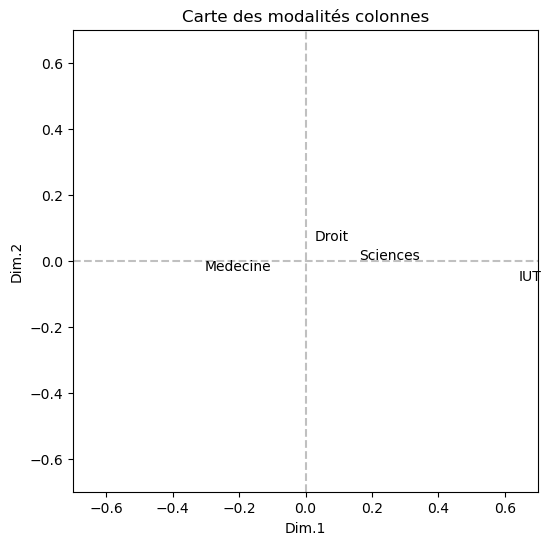

In [23]:
#affichage dans le premier plan factoriel
fig, ax = plt.subplots(figsize=(6,6))
ax.axis([-0.7,+0.7,-0.7,+0.7])
ax.plot([-0.7,+0.7],[0,0],color='silver',linestyle='--')
ax.plot([0,0],[-0.7,+0.7],color='silver',linestyle='--')
ax.set_xlabel("Dim.1")
ax.set_ylabel("Dim.2")
plt.title("Carte des modalités colonnes")

for i in range(D.shape[1]):
    ax.text(afc.col_coord_[i,0],afc.col_coord_[i,1],D.columns[i])

plt.show()

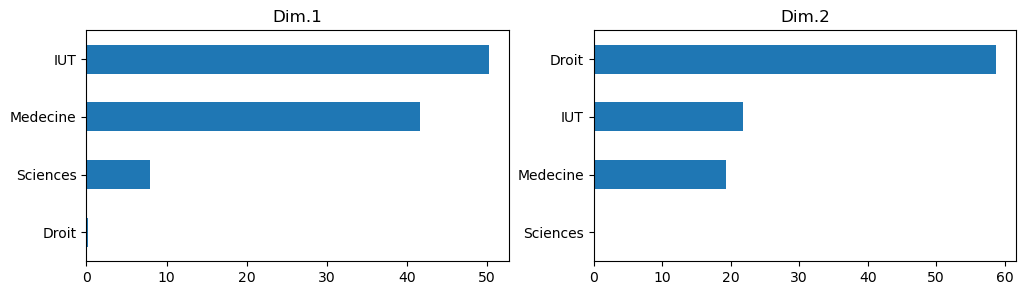

In [22]:
# Informations sur les contributions des lignes
df = afc.col_topandas()[['col_contrib_dim1',
                         'col_contrib_dim2']]
                         
r1 = df.iloc[:,0]
r2 = df.iloc[:,1]

# https://www.statology.org/pandas-subplots/
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,3))


r1.sort_values().plot(kind='barh', ax=axes[0], title='Dim.1')
r2.sort_values().plot(kind='barh', ax=axes[1], title='Dim.2')

plt.show()


### Graphiques et interprétation du premier plan factoriel

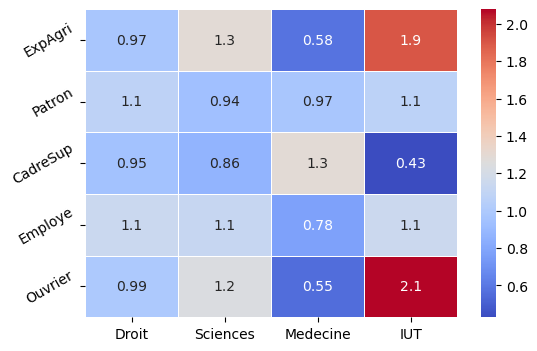

In [26]:
### Indice d'attraction et répulsion
# Valeurs du tableau original divisé par le tableau à l'indépendance
IAR = D.values/dfe
IAR.columns= D.columns
IAR.index=D.index
# IAR.style.background_gradient(cmap='coolwarm')


tableau = IAR

fig, ax = plt.subplots(figsize=(6,4))         
# Sample figsize in inches
g = sns.heatmap(tableau, annot=tableau, cmap="coolwarm", linewidths=.5, ax=ax)
labels = tableau.index
p = g.set_yticklabels(labels, rotation=30)

### Interprétation: 
# si les valeurs sont proches de 1 indépendance
# si supérieures à 1: attrait
# si inférieures à 1: répulsion 
plt.show()

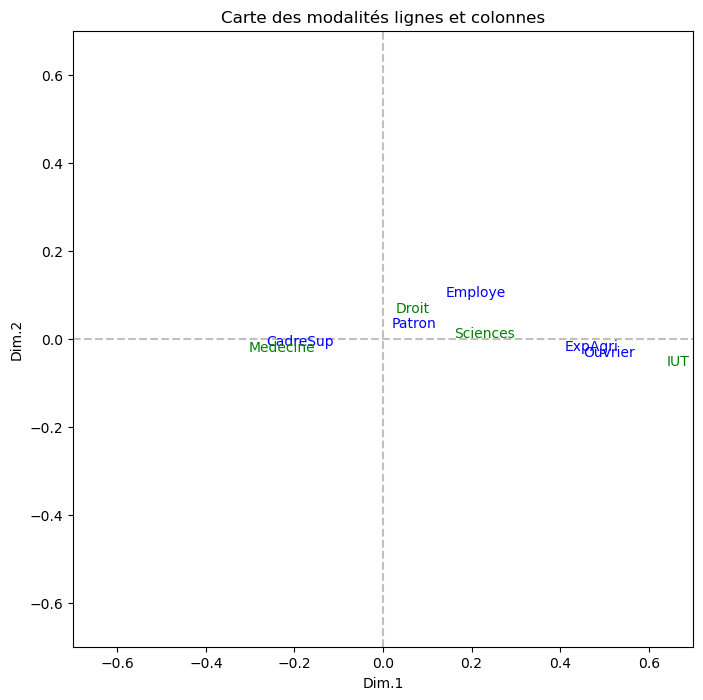

In [25]:
# Représentation simultanée, sans amplification
fig, ax = plt.subplots(figsize=(8,8))
ax.axis([-0.7,+0.7,-0.7,+0.7])
ax.plot([-0.7,+0.7],[0,0],color='silver',linestyle='--')
ax.plot([0,0],[-0.7,+0.7],color='silver',linestyle='--')
ax.set_xlabel("Dim.1")
ax.set_ylabel("Dim.2")
plt.title("Carte des modalités lignes et colonnes")
#modalités ligne
for i in range(D.shape[0]):
    ax.text(afc.row_coord_[i,0],afc.row_coord_[i,1],D.index[i],color='blue')
#modalités colonne
for i in range(D.shape[1]):
    ax.text(afc.col_coord_[i,0],afc.col_coord_[i,1],D.columns[i],color='green')
plt.show()

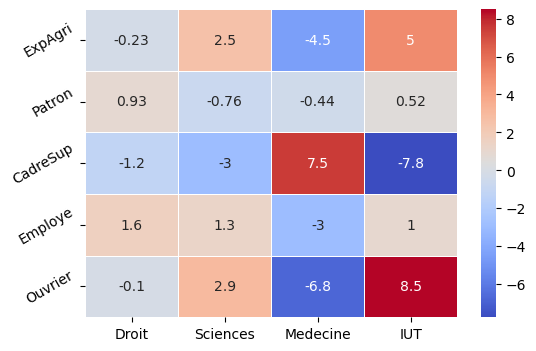

In [27]:
### Résidus pondérés (avec le signe)
### Doc. :
#   Rakotomalala, p.240
residus_ponderes = (round((D.values-dfe)/np.sqrt(dfe),2))
residus_ponderes.columns= D.columns
residus_ponderes.index=D.index


fig, ax = plt.subplots(figsize=(6,4))         
# Sample figsize in inches
g = sns.heatmap(residus_ponderes, annot=residus_ponderes, cmap="coolwarm", linewidths=.5, ax=ax)
labels = residus_ponderes.index
p = g.set_yticklabels(labels, rotation=30)

plt.show()


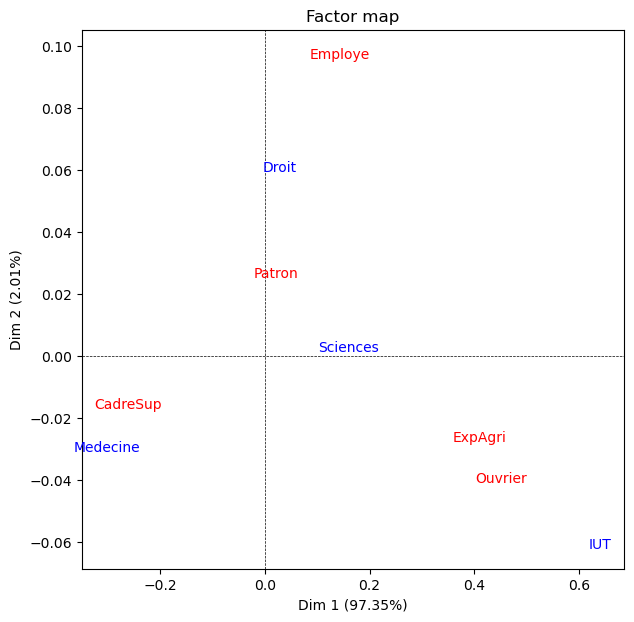

In [28]:
# Représentation simultanée, avec amplification
afc.mapping(num_x_axis=1,num_y_axis=2,figsize=(7,7))

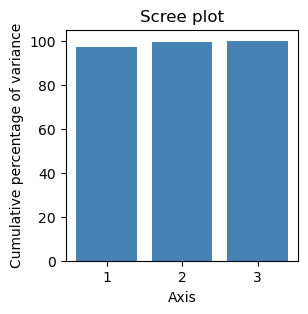

In [29]:
### Combien sont les facteurs et quelle part d'inertie 
# ou variance expriment-ils?
afc.plot_eigenvalues(type='cumulative', figsize=(3,3))

## Vente de produits en relation avec les régions


Données issues de Bennani, 2011, chapitre 2.

In [31]:
d = {'Ouest':[28,14, 45,33,12], 'Sud':[36,21,25,64,23], 
     'Est':[21, 64, 38, 11, 7], 'Nord':[79,42,67,9,41]}
ddf = pd.DataFrame(d)
ddf = ddf.transpose()
ddf.columns= ['P1', 'P2', 'P3', 'P4', 'P5']
D = ddf.copy(deep=True)
D


,P1,P2,P3,P4,P5
Ouest,28,14,45,33,12
Sud,36,21,25,64,23
Est,21,64,38,11,7
Nord,79,42,67,9,41


In [32]:
## Ajouter une ligne avec totaux des colonnes
ddf.loc['Total']= ddf.sum()
## Ajouter une colonnne avec totaux des lignes
ddf['Total'] = ddf.sum(axis=1)
ddf

,P1,P2,P3,P4,P5,Total
Ouest,28,14,45,33,12,132
Sud,36,21,25,64,23,169
Est,21,64,38,11,7,141
Nord,79,42,67,9,41,238
Total,164,141,175,117,83,680


In [34]:
## Nombre de modalités ligne, 
# variable: catégories socio-professionnelles des parents
K = D.shape[0]
## Nombre de modalités colonnes,
# variable : filière d'études chosie
L = D.shape[1]
# Effectif total
n = np.sum(D.values)
# Nombre max. de facteur
Hmax = np.min([K-1,L-1])

print('Dimensions: (', K, ',', L, '), effectif:', n, ', nombre max. facteurs:', Hmax)

Dimensions: ( 4 , 5 ), effectif: 680 , nombre max. facteurs: 3


In [35]:
### Valeurs produites par une fonction
statistic, p, dof, expected = stats.chi2_contingency(D)

print('Chi2 :', statistic, ', dof :',dof)
print('p-value :', p)


print('phi2 = inertie (variance totale) :', statistic/n)


### Tableau à l'indépendance
dfe = round(pd.DataFrame(expected),4)

### Coéfficient de Cramer
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.contingency.association.html

vc = stats.contingency.association(D.iloc[:-1,:-1], method='cramer')
print('Cramer: ', vc)

Chi2 : 171.84495622957783 , dof : 12
p-value : 2.0017466576875573e-30
phi2 = inertie (variance totale) : 0.2527131709258498
Cramer:  0.33436690519801593


In [36]:
afc = CA(row_labels=D.index,col_labels=D.columns)
afc.fit(D.values)

CA(col_labels=Index(['P1', 'P2', 'P3', 'P4', 'P5'], dtype='object'),
   row_labels=Index(['Ouest', 'Sud', 'Est', 'Nord'], dtype='object'))

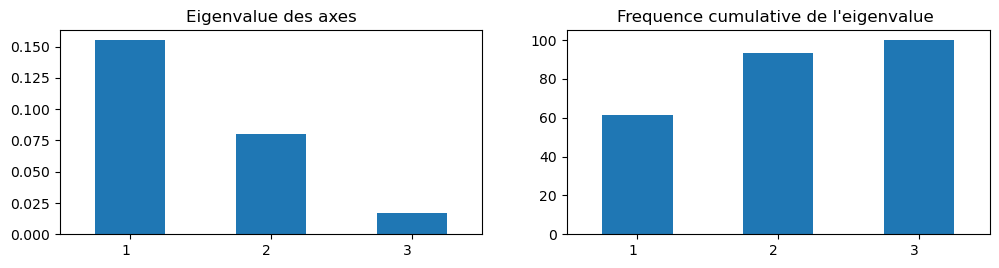

In [38]:
eig = pd.DataFrame(afc.eig_)

r1 = eig.iloc[0]
r2 = eig.iloc[2]
s=list(range(1,len(r1)+1))
r1.index=s
r2.index=s

# https://www.statology.org/pandas-subplots/
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,3))

r1.plot(kind='bar', ax=axes[0], title='Eigenvalue des axes')
r2.plot(kind='bar', ax=axes[1], title="Frequence cumulative de l'eigenvalue ")
# Met les valeurs xticks en vertical
fig.autofmt_xdate(rotation=0)
plt.show()

### Distances des lignes / des colonnes

In [41]:
# Calcul des profils des lignes
prof_lig = np.apply_along_axis(arr=D.values,axis=1,
                               func1d=lambda x:x/np.sum(x))
# Calul du profil marginal correspondant
# Cf. ligne grisée de Figure 100, Rakotomalala, 2020
tot_col = ddf.loc['Total'][:5]
prof_marg_lig = tot_col/np.sum(tot_col)

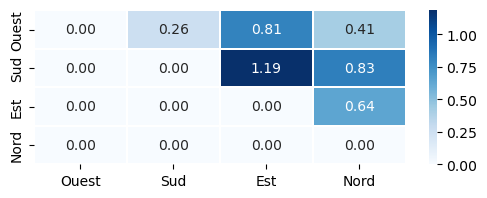

In [42]:
### Distance entre paires de modalités lignes,
# calculée sur la base des valeurs dans la note précédente

fig, ax = plt.subplots(figsize=(6,2))

distPairesLig = np.zeros(shape=(prof_lig.shape[0],prof_lig.shape[0]))
#double boucle
for i in range(prof_lig.shape[0]):
    for j in range(i+1,prof_lig.shape[0]):
        distPairesLig[i,j] = np.sum((prof_lig[i,:]-prof_lig[j,:])**2/prof_marg_lig)

sns.heatmap(distPairesLig,vmin=0,vmax=np.max(distPairesLig),linewidth=0.1,cmap=
'Blues',xticklabels=D.index,yticklabels=D.index,
fmt=".2f", annot=True)


### ATTENTION: plus la couleur est foncée, plus la distance est grande
plt.show()

In [43]:
# Profil marginal des filières (colonnes)
tot_lig = np.sum(D.values,axis=1)
prof_marg_col = tot_lig/np.sum(tot_lig)

# Tableau des profils colonnes
prof_col = np.apply_along_axis(arr=D.values,axis=0,
                               func1d=lambda x:x/np.sum(x))
#print(pd.DataFrame(prof_col,index=D.index,columns=D.columns))
### Transposer pour garder la structure du code Python des lignes 
t_prof_col = prof_col.T

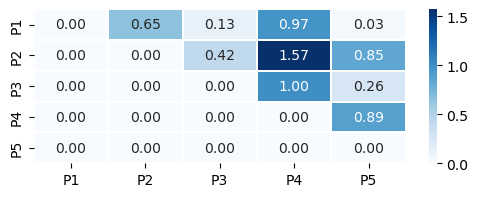

In [44]:
### Distance entre paires de modalités colonnes,
# calculée sur la base des valeurs précédentes  

fig, ax = plt.subplots(figsize=(6,2))


distPairesCol = np.zeros(shape=(t_prof_col.shape[0],
                                t_prof_col.shape[0]))
#double boucle
for i in range(t_prof_col.shape[0]-1):
    for j in range(i+1,t_prof_col.shape[0]):        
        distPairesCol[i,j] = np.sum((t_prof_col[i,:]-t_prof_col[j,:])**2/prof_marg_col)
#distPairesLig[j,i] = distPairesLig[i,j]
#affichage
#print(pd.DataFrame(distPairesLig,index=D.index,columns=D.index))

sns.heatmap(distPairesCol,vmin=0,vmax=np.max(distPairesCol),
            linewidth=0.1,cmap='Blues',xticklabels=D.columns,
            yticklabels=D.columns, 
fmt=".2f", annot=True)

plt.show()

### Graphiques et interprétation du premier plan factoriel

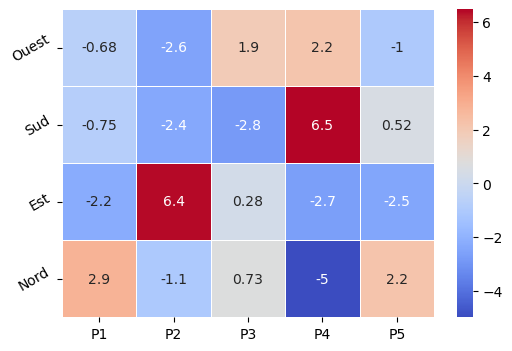

In [48]:
### Résidus pondérés (avec le signe)
### Doc. :
#   Rakotomalala, p.240
residus_ponderes = (round((D.values-dfe)/np.sqrt(dfe),2))
residus_ponderes.columns= D.columns
residus_ponderes.index=D.index


fig, ax = plt.subplots(figsize=(6,4))         
# Sample figsize in inches
g = sns.heatmap(residus_ponderes, annot=residus_ponderes, cmap="coolwarm", linewidths=.5, ax=ax)
labels = residus_ponderes.index
p = g.set_yticklabels(labels, rotation=30)

plt.show()


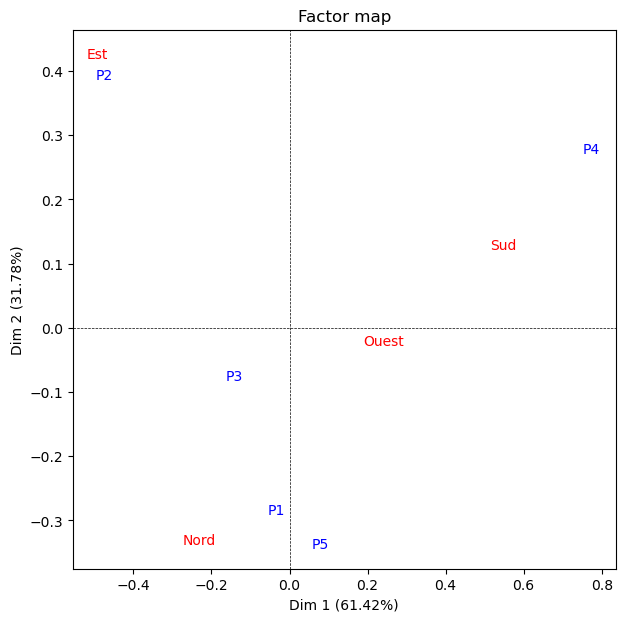

In [49]:
# Représentation simultanée, avec amplification
afc.mapping(num_x_axis=1,num_y_axis=2,figsize=(7,7))

### Représenter trois axes factoriels

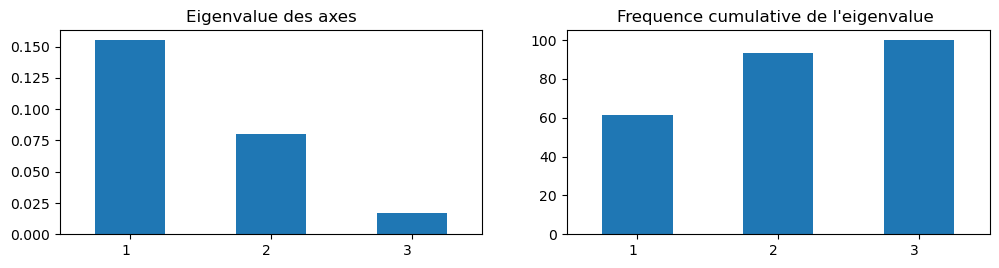

In [51]:
eig = pd.DataFrame(afc.eig_)

r1 = eig.iloc[0]
r2 = eig.iloc[2]
s=list(range(1,len(r1)+1))
r1.index=s
r2.index=s

# https://www.statology.org/pandas-subplots/
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,3))

r1.plot(kind='bar', ax=axes[0], title='Eigenvalue des axes')
r2.plot(kind='bar', ax=axes[1], title="Frequence cumulative de l'eigenvalue ")
# Met les valeurs xticks en vertical
fig.autofmt_xdate(rotation=0)
plt.show()

In [52]:
D3fr = afc.row_topandas()[['row_coord_dim1','row_coord_dim2','row_coord_dim3']]
# D3fr
D3fc = afc.col_topandas()[['col_coord_dim1','col_coord_dim2','col_coord_dim3']]
#D3fc

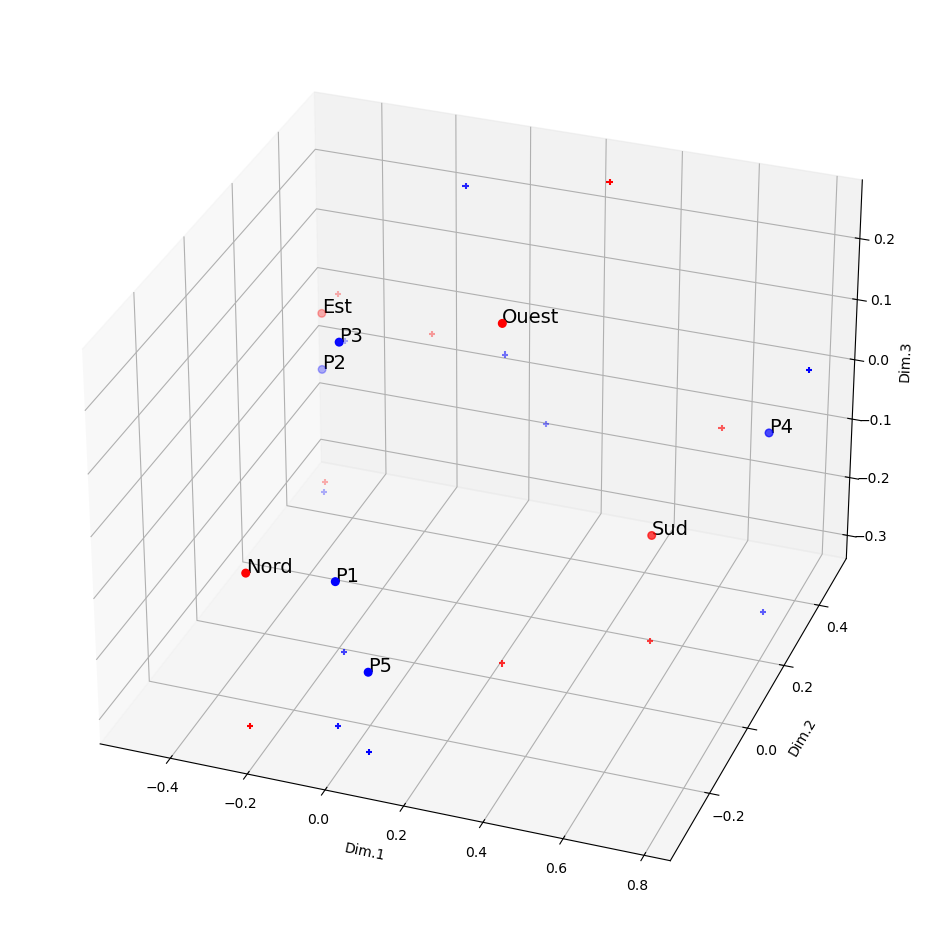

In [58]:
# plot a 3D wireframe like in the example mplot3d/wire3d_demo

fig = plt.figure(figsize=(12,12), )
ax = fig.add_subplot(111, projection='3d')

r1 = D3fr.iloc[:,0]
r2 = D3fr.iloc[:,1]
r3 = D3fr.iloc[:,2]

c1 = D3fc.iloc[:,0]
c2 = D3fc.iloc[:,1]
c3 = D3fc.iloc[:,2]


# h=[min(D3fr[2])] 
hz=[-0.3]
hy=[0.5]

### rows
ax.scatter(r1,r2,r3, c='red', s=30)

for x,y,z,i in zip(r1,r2,r3,D3fr.index):
    ax.text(x,y,z,i, fontsize=14)

bx = hz * len(D3fr)
ax.scatter(r1,r2,bx, marker='+', c='red', s=20)
bx = hy * len(D3fr)
ax.scatter(r1,bx,r3, marker='+', c='red', s=20)

### columns
ax.scatter(c1,c2,c3, c='blue', s=30)

for x,y,z,i in zip(c1,c2,c3,D3fc.index):
    ax.text(x,y,z,i, fontsize=14)

# projection sur le plan horizontal, axes 1 et 2
by = hz * len(D3fc)
ax.scatter(c1,c2,by, marker='+', c='blue', s=20)
# projection sur le plan vertical, axes 2 et 3
by = hy * len(D3fc)
ax.scatter(c1,by,c3, marker='+', c='blue', s=20)

ax.set_xlabel("Dim.1")
ax.set_ylabel("Dim.2")
ax.set_zlabel("Dim.3")

### Position:
# https://matplotlib.org/stable/api/toolkits/mplot3d/view_angles.html
# Il faut travailler sur les angles pour améliorer la visualisation
ax.view_init(elev=30, azim=-70, roll=0)

#ax.zaxis.labelpad=-1.5

plt.show()

In [65]:
afc.row_topandas().iloc[:,:3]

,row_coord_dim1,row_coord_dim2,row_coord_dim3
Ouest,0.241106,-0.020616,0.254577
Sud,0.549082,0.127721,-0.122847
Est,-0.491634,0.426133,-0.008570
Nord,-0.232355,-0.331715,-0.048885


In [ ]:
afc.col_topandas().iloc[:,:3]

,col_coord_dim1,col_coord_dim2,col_coord_dim3
P1,-0.033467,-0.284807,-0.062156
P2,-0.473736,0.393783,-0.087507
P3,-0.140294,-0.075953,0.208540
P4,0.772257,0.277358,0.000298
P5,0.078106,-0.337038,-0.168643


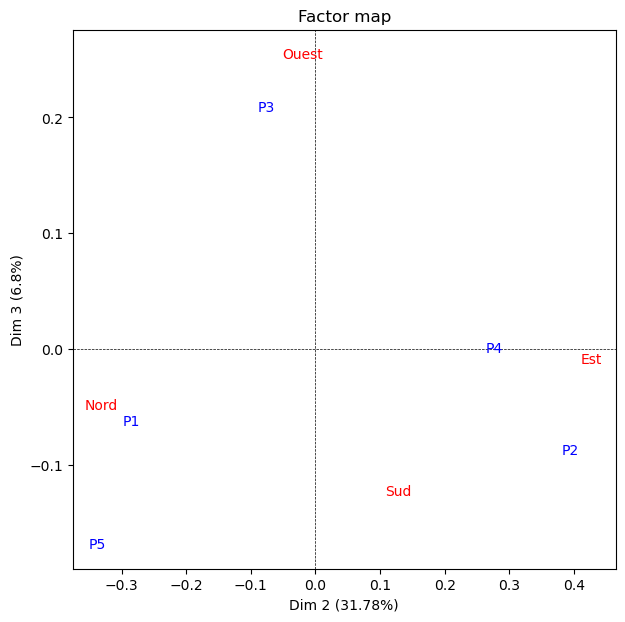

In [55]:
# Représentation simultanée, avec amplification
afc.mapping(num_x_axis=2,num_y_axis=3,figsize=(7,7))

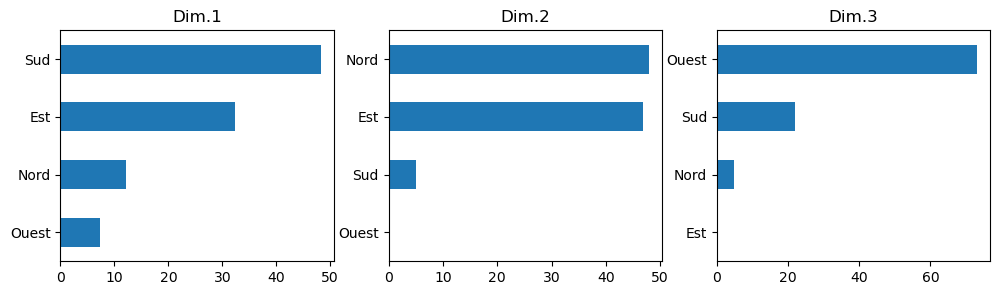

In [77]:
# Informations sur les contributions des lignes
df = afc.row_topandas()[['row_contrib_dim1',
                         'row_contrib_dim2',
                         'row_contrib_dim3']]

r1 = df.iloc[:,0]
r2 = df.iloc[:,1]
r3 = df.iloc[:,2]

# https://www.statology.org/pandas-subplots/
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,3))


r1.sort_values().plot(kind='barh', ax=axes[0], title='Dim.1')
r2.sort_values().plot(kind='barh', ax=axes[1], title='Dim.2')
r3.sort_values().plot(kind='barh', ax=axes[2], title='Dim.3')

plt.show()


In [78]:
### Valeurs
df.style.background_gradient(cmap='Blues')

,row_contrib_dim1,row_contrib_dim2,row_contrib_dim3
Ouest,7.269612,0.102742,73.215882
Sud,48.270558,5.048619,21.827881
Est,32.286697,46.889374,0.088634
Nord,12.173132,47.959265,4.867603


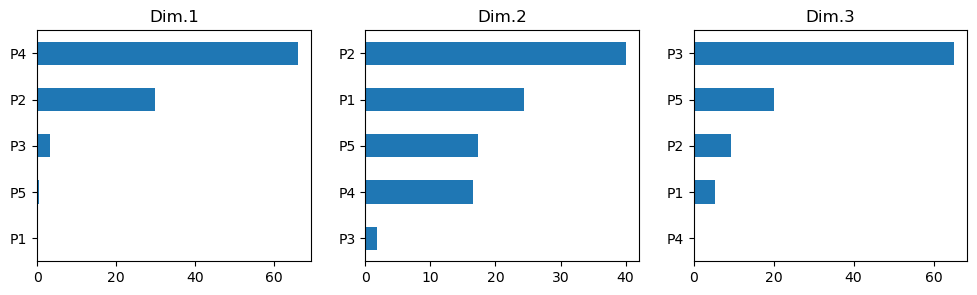

In [79]:
# Informations sur les contributions des colonnes
df = afc.col_topandas()[['col_contrib_dim1',
                         'col_contrib_dim2',
                         'col_contrib_dim3']]

r1 = df.iloc[:,0]
r2 = df.iloc[:,1]
r3 = df.iloc[:,2]

# https://www.statology.org/pandas-subplots/
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,3))


r1.sort_values().plot(kind='barh', ax=axes[0], title='Dim.1')
r2.sort_values().plot(kind='barh', ax=axes[1], title='Dim.2')
r3.sort_values().plot(kind='barh', ax=axes[2], title='Dim.3')

plt.show()


In [80]:
### Valeurs
df.style.background_gradient(cmap='Blues')

,col_contrib_dim1,col_contrib_dim2,col_contrib_dim3
P1,0.174018,24.361765,5.422536
P2,29.978723,40.040216,9.240473
P3,3.263168,1.848807,65.134284
P4,66.104390,16.482847,0.000089
P5,0.479701,17.266365,20.202618
